In [10]:
# путь к папке с моделями
model_path = "./"

In [11]:
# класс и методы необходимые для SVD разложения
from typing import Union

import torch
from torch import Tensor
from torch.nn import Conv2d, Parameter, Module
from torch.nn.common_types import _size_2_t
import os

class DecomposedConv2d(Conv2d):
    """Extends the Conv2d layer by implementing the singular value decomposition of
    the weight matrix.
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: _size_2_t,
        stride: _size_2_t = 1,
        padding: Union[str, _size_2_t] = 0,
        dilation: _size_2_t = 1,
        groups: int = 1,
        bias: bool = True,
        padding_mode: str = "zeros",
        decomposing: bool = True,
        decomposing_mode: str = "channel",
        device=None,
        dtype=None,
    ) -> None:

        super().__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            groups,
            bias,
            padding_mode,
            device,
            dtype,
        )

        n, c, w, h = self.weight.size()
        self.decomposing_modes_dict = {
            "channel": (n, c * w * h),
            "spatial": (n * w, c * h),
        }

        if decomposing:
            self.decompose(decomposing_mode)
        else:
            self.U = None
            self.S = None
            self.Vh = None
            self.decomposing = False

    def decompose(self, decomposing_mode: str) -> None:
        """Decompose the weight matrix in singular value decomposition."""

        if decomposing_mode not in self.decomposing_modes_dict.keys():
            raise ValueError(
                "decomposing_mode must be one of {}, but got decomposing_mode='{}'".format(
                    self.decomposing_modes_dict.keys(), decomposing_mode
                )
            )
        W = self.weight.view(self.decomposing_modes_dict[decomposing_mode])
        U, S, Vh = torch.linalg.svd(W, full_matrices=False)

        self.U = Parameter(U)
        self.S = Parameter(S)
        self.Vh = Parameter(Vh)
        self.register_parameter("weight", None)
        self.decomposing = True

    def compose(self) -> None:
        """Compose the weight matrix from singular value decomposition."""

        W = self.U @ torch.diag(self.S) @ self.Vh
        self.weight = Parameter(
            W.view(
                self.out_channels, self.in_channels // self.groups, *self.kernel_size
            )
        )

        self.register_parameter("U", None)
        self.register_parameter("S", None)
        self.register_parameter("Vh", None)
        self.decomposing = False

    def forward(self, input: Tensor) -> Tensor:

        if self.decomposing:
            W = self.U @ torch.diag(self.S) @ self.Vh
            return self._conv_forward(
                input,
                W.view(
                    self.out_channels,
                    self.in_channels // self.groups,
                    *self.kernel_size
                ),
                self.bias,
            )
        else:
            return self._conv_forward(input, self.weight, self.bias)

    def set_U_S_Vh(self, u: Tensor, s: Tensor, vh: Tensor) -> None:
        """Update U, S, Vh matrices."""

        assert self.decomposing, "for setting U, S and Vh, the model must be decomposed"
        self.U = Parameter(u)
        self.S = Parameter(s)
        self.Vh = Parameter(vh)

def energy_threshold_pruning(conv: DecomposedConv2d, energy_threshold: float) -> None:
    """Prune the weight matrices to the energy_threshold (in-place)."""
    assert conv.decomposing, "for pruning, the model must be decomposed"
    S, indices = conv.S.sort()
    U = conv.U[:, indices]
    Vh = conv.Vh[indices, :]
    sum = (S ** 2).sum()
    threshold = energy_threshold * sum
    for i, s in enumerate(S):
        sum -= s ** 2
        if sum < threshold:
            conv.set_U_S_Vh(U[:, i:].clone(), S[i:].clone(), Vh[i:, :].clone())
            break


def decompose_module(model: Module, decomposing_mode: str = "channel") -> None:
    """Replace Conv2d layers with DecomposedConv2d layers in module (in-place)."""
    for name, module in model.named_children():
        if len(list(module.children())) > 0:
            decompose_module(module, decomposing_mode=decomposing_mode)

        if isinstance(module, Conv2d):
            new_module = DecomposedConv2d(
                in_channels=module.in_channels,
                out_channels=module.out_channels,
                kernel_size=module.kernel_size,
                stride=module.stride,
                padding=module.padding,
                dilation=module.dilation,
                groups=module.groups,
                bias=(module.bias is not None),
                padding_mode=module.padding_mode,
                decomposing=False,
            )
            new_module.load_state_dict(module.state_dict())
            new_module.decompose(decomposing_mode=decomposing_mode)
            setattr(model, name, new_module)

def prune_model(model, energy_threshold) -> None:
    """Prune the model weights to the energy_threshold."""
    for module in model.modules():
        if isinstance(module, DecomposedConv2d):
            energy_threshold_pruning(conv=module, energy_threshold=energy_threshold)

def number_of_params(model) -> int:
    """Return number of model parameters."""
    return sum(p.numel() for p in model.parameters())

In [12]:
from NetBayesianization import wrap, api
from torchvision.datasets import CIFAR10
import torchvision.transforms as TF

In [13]:
from torchmetrics.classification import MulticlassAccuracy
metric = MulticlassAccuracy(num_classes=10)

In [14]:
import torchvision.transforms as TF

tfm = TF.Compose([
    TF.ToTensor(),
    TF.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_ds = CIFAR10(root='./.cache', train=True, download=True, 
                 transform=tfm) #TF.ToTensor()) 
test_ds = CIFAR10(root='./.cache', train=False, download=False, 
                transform=tfm)#TF.ToTensor())

Files already downloaded and verified


In [15]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)

In [16]:
import torch
from torchvision.models import resnet18

# загрузка обученной модели без разложения
device = torch.device('cpu')
model_name = "ResNet18.sd.pt"
model = resnet18(num_classes=10)
model.load_state_dict(torch.load(model_path + model_name,  map_location=device))
print(f"Number of parameters: {number_of_params(model)}")

model.eval()

Number of parameters: 11181642


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
import torch
import torch.nn as nn
import copy
import torch.optim
import numpy as np

In [35]:
def sampling(model, data):
    max_val = []
    min_val = []
    avg_val = []
    for p in np.arange(0, 1.1, 0.1):
        results = []
        model_copy = copy.deepcopy(model)
        state_dict = model_copy.state_dict()
        state_dict_v2 = copy.deepcopy(state_dict)
        for key, value in state_dict_v2.items():
            if 'weight' in key:
                output = nn.functional.dropout(value, p, training=True)
                state_dict_v2[key] = output
        model_copy.load_state_dict(state_dict_v2, strict=True)
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(data):
                outputs = model_copy(inputs)
                results.append(metric(outputs, targets).numpy())
            max_val.append(np.max(results))
            min_val.append(np.min(results))
            avg_val.append(np.mean(results))
    return max_val, min_val, avg_val

#построить график


In [36]:
max_val, min_val, avg_val = sampling(model, test_dl)
print(max_val)
print(min_val)
print(avg_val)

[0.952381, 0.8616667, 0.65642864, 0.3742857, 0.25000003, 0.15, 0.15, 0.3, 0.25333333, 0.23333335, 0.1]
[0.45499998, 0.32833332, 0.125, 0.06666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.7386384, 0.60742223, 0.37249228, 0.21158373, 0.10947577, 0.09836833, 0.09693723, 0.10609983, 0.09739098, 0.1007664, 0.09840257]


In [37]:
import matplotlib.pyplot as plt

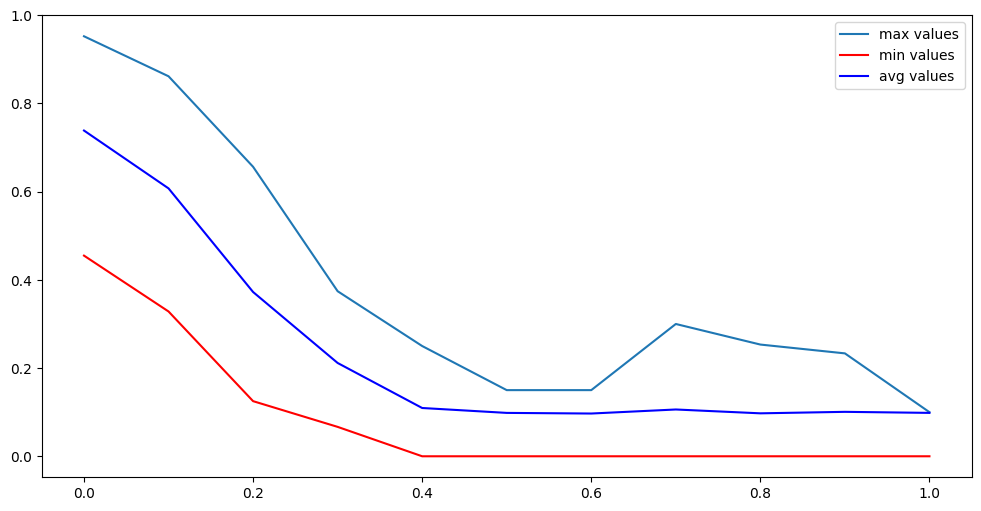

In [45]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(np.arange(0, 1.1, 0.1), max_val, label='max values')
ax1.plot(np.arange(0, 1.1, 0.1), min_val, color="r", label='min values')
ax1.plot(np.arange(0, 1.1, 0.1), avg_val, color="b", label='avg values')
ax1.legend()

In [46]:
with torch.no_grad():
    n = 0 
    test_acc = 0 
    for batch_idx, (inputs, targets) in enumerate(test_dl):
        outputs = model(inputs)
        test_acc += metric(outputs, targets)
        n += 1
    
    test_acc = test_acc / n
    print(test_acc)

tensor(0.7386)


In [10]:
bayes_model = api.BasicBayesianWrapper(model, 'basic', 0.05, None, None)
n_iter = 10

In [11]:
with torch.no_grad():
    n = 0 
    test_acc = 0 
    for batch_idx, (inputs, targets) in enumerate(test_dl):
        test = bayes_model.predict(inputs, n_iter)
        test_acc += metric(test['mean'], targets)
        n += 1
    
    test_acc = test_acc / n
    print(test_acc)

tensor(0.7341)


In [12]:
bayes_model = api.BasicBayesianWrapper(model, 'beta', None, 0.2, 4.0)
n_iter = 10

In [13]:
with torch.no_grad():
    n = 0 
    test_acc = 0 
    for batch_idx, (inputs, targets) in enumerate(test_dl):
        test = bayes_model.predict(inputs, n_iter)
        test_acc += metric(test['mean'], targets)
        n += 1
    
    test_acc = test_acc / n
    print(test_acc)

tensor(0.7029)


In [14]:
# загрузка обученной разложенной модели
svd_model_name = 'ResNet18_SVD_channel_O-100.0_H-0.000100.sd.pt'
svd_model = resnet18(num_classes=10)
decompose_module(svd_model, "channel")
svd_model.load_state_dict(torch.load(model_path + svd_model_name,  map_location=device))
print(f"Number of parameters: {number_of_params(svd_model)}")
 
svd_model.eval()

Number of parameters: 12668746


ResNet(
  (conv1): DecomposedConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): DecomposedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): DecomposedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): DecomposedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [15]:
n = 0 
test_acc = 0 
for batch_idx, (inputs, targets) in enumerate(test_dl):
    outputs = svd_model(inputs)
    test_acc += metric(outputs, targets)
    n += 1

test_acc = test_acc / n
print(test_acc)

tensor(0.7276)


In [16]:
bayes_model = api.BasicBayesianWrapper(svd_model, 'basic', 0.05, None, None)
n_iter = 10

In [17]:
n = 0 
test_acc = 0 
for batch_idx, (inputs, targets) in enumerate(test_dl):
    test = bayes_model.predict(inputs, n_iter)
    test_acc += metric(test['mean'], targets)
    n += 1

test_acc = test_acc / n
print(test_acc)

tensor(0.7215)


In [18]:
bayes_model = api.BasicBayesianWrapper(svd_model, 'beta', None, 0.2, 4.0)
n_iter = 10

In [19]:
n = 0 
test_acc = 0 
for batch_idx, (inputs, targets) in enumerate(test_dl):
    test = bayes_model.predict(inputs, n_iter)
    test_acc += metric(test['mean'], targets)
    n += 1

test_acc = test_acc / n
print(test_acc)

tensor(0.7025)


In [20]:
import copy

#обрезка модели, значения energy_threshold из промежутка (0, 1)
pruned_model = copy.deepcopy(svd_model)
prune_model(model=pruned_model, energy_threshold=0.9)
print(f"Number of parameters: {number_of_params(pruned_model)}")
pruned_model.eval()

Number of parameters: 7206832


ResNet(
  (conv1): DecomposedConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): DecomposedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): DecomposedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): DecomposedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [21]:
n = 0 
test_acc = 0 
for batch_idx, (inputs, targets) in enumerate(test_dl):
    outputs = pruned_model(inputs)
    test_acc += metric(outputs, targets)
    n += 1

test_acc = test_acc / n
print(test_acc)

tensor(0.5925)


In [22]:
bayes_model = api.BasicBayesianWrapper(pruned_model, 'basic', 0.05, None, None)
n_iter = 10

In [23]:
n = 0 
test_acc = 0 
for batch_idx, (inputs, targets) in enumerate(test_dl):
    test = bayes_model.predict(inputs, n_iter)
    test_acc += metric(test['mean'], targets)
    n += 1

test_acc = test_acc / n
print(test_acc)

tensor(0.6058)


In [24]:
bayes_model = api.BasicBayesianWrapper(pruned_model, 'beta', None, 0.2, 4.0)
n_iter = 10

In [25]:
n = 0 
test_acc = 0 
for batch_idx, (inputs, targets) in enumerate(test_dl):
    test = bayes_model.predict(inputs, n_iter)
    test_acc += metric(test['mean'], targets)
    n += 1

test_acc = test_acc / n
print(test_acc)

tensor(0.5931)
